In [2]:
#import packages
import numpy as np
from matplotlib import pyplot
import time, sys
import math
import matplotlib.pyplot as plt
from matplotlib import rc
import sympy
from sympy.solvers import solve
from sympy import Symbol
from sympy import *

# Potential Flow 
The Navier-Stokes equations are notoriously difficult to solve, with very few analytical solutions existing. This is due to the presence of nonlinear terms (namely, the convective acceleration terms). On the other hand, irrotational, incompressible, and inviscid flows are linear, which are the conditions that are assumed when studying **potential flow**. By definition, irrotational flow satisfies
$$\nabla \times \mathbf{u} = 0 $$
where $\mathbf{u}$ is the velocity vector of the fluid. We define the *velocity potential* $\phi$ as
$$\mathbf{u} = \nabla \phi = \frac{\partial \phi}{\partial x} + \frac{\partial \phi}{\partial y}$$
If there is a vector $\boldsymbol{\psi}$ that satisfies
$$\mathbf{u} = \nabla \times \boldsymbol{\psi} $$
then the fluid is **automatically incompressible**. For 2D flow, $\boldsymbol{\psi} = \psi \mathbf{k}$, where $\psi$ is the *streamfunction*. It is imperative to understand that the velocity potential $\phi$ only exists if the flow is irrotational—viscous flows are inherently rotational, so we must limit our study to inviscid flow. In Cartesian coordinates, the velocity potential and streamfunction have the following relationships to the velocity components:
$$u = \frac{\partial \phi}{\partial x} = \frac{\partial \psi}{\partial y} \text{ and } v = \frac{\partial \phi}{\partial y} = -\frac{\partial \psi}{\partial x} $$
From the continuity equation,
$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = \frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} = \nabla^2 \phi $$
Because the continuity equation equates to 0, the velocity potential automatically satisfies Laplace's equation:
$$\nabla^2 \phi = 0$$
The streamfunction also satisfies Laplace's equation by applying the irrotational condition.
$$\nabla \times \mathbf{u} = \left(\frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} \right)\mathbf{k} = \left( -\frac{\partial^2 \psi}{\partial x^2} - \frac{\partial^2 \psi}{\partial y^2}\right)\mathbf{k} = -\nabla^2 \psi \mathbf{k} = 0$$
$$\Longrightarrow \nabla^2 \psi = 0$$
Since Laplace's equation is linear, we can apply the principle of superposition when solving problems.

# Uniform Flow
For uniform flow, the velocity, streamfunction, and velocity potential components are
$$u = U_\infty\cos(\theta), \quad v = U_\infty\sin(\theta), \quad \psi = U_\infty\left(y\cos\theta - x\sin\theta \right), \quad \phi = U_\infty\left(x\cos\theta + y\sin\theta\right)  $$
First, we create a finite-difference mesh (or grid) where $0 \leq x \leq h$ and $0 \leq y \leq h$. For a total of $N$ lines in both the horizontal and vertical directions, the spacing between each node is
$$\Delta x = \Delta y = \frac{h}{N - 1} $$
In Python, we can create arrays that store the coordinates of the nodes using linspace(). We will also generate the mesh onto a figure to verify that everything is working.

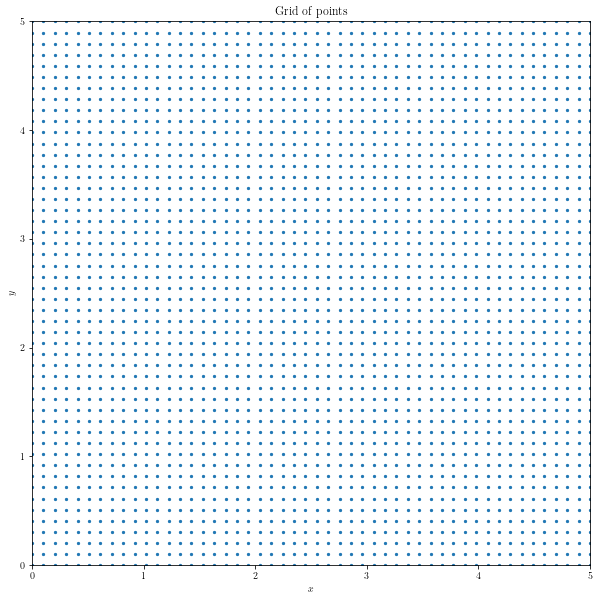

In [3]:
#Set up the grid 
%matplotlib inline
N = 50;                                        #number of lines in each direction
x_lower, x_upper = 0, 5                        #x limit boundaries
y_lower, y_upper = 0, 5                        #y limit boundaries
x_grid = np.linspace(x_lower, x_upper, N)      #points along the grid in the x direction
y_grid = np.linspace(y_lower, y_upper, N)      #points along the grid in the y direction
x_dir, y_dir = np.meshgrid(x_grid, y_grid)     #create the grid
L = 10
H = 10

#Plot data
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(L,H))
plt.title(r'Grid of points')
plt.xlim(x_lower, x_upper)
plt.ylim(y_lower, y_upper)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.scatter(x_dir, y_dir, s=5);

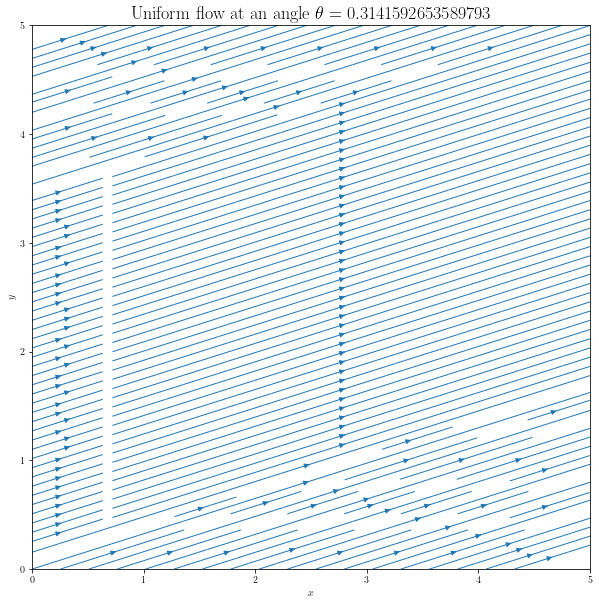

In [4]:
U = 10               #speed of uniform flow in [m/s]
θ = math.pi/10       #angle of flow with respect to x axis in [radians]
u = np.zeros((N,N))  #array that stores u component at each point
v = np.zeros((N,N))  #array that stores v component at each point
for k in range(N):
    for j in range(N):
        #Populate grid with the same values (uniform flow does not vary)
        u[k][j] = U * cos(θ)
        v[k][j] = U * sin(θ)

#Plot data
plt.figure(figsize=(L,H))
plt.title(r'Uniform flow at an angle $\theta = {}$'.format(θ),fontsize=18)
plt.xlim(x_lower, x_upper)
plt.ylim(y_lower, y_upper)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.streamplot(x_dir, y_dir, u, v, density=2, linewidth=1);  #semicolon suppresses line from being output

# Source/Sink
A source (or sink) is a point where a fluid flows radially outward or inward. Because of the nature of this flow, it is convenient to convert to cylindrical coordinates when generating streamlines. The velocity components, streamfunction, and velocity potential are
$$u_r = \frac{Q}{2\pi r}, \quad u_\theta = 0, \quad \psi = \frac{Q\theta}{2\pi},\quad \phi = \frac{Q}{2\pi}\ln r $$
where $Q$ is the source strength (it is also the volumetric flow rate from the source/sink). The fact that $u_\theta = 0$ is due to the fact that the streamlines are straight and do not rotate. However, computationally expressing the velocity components in Cartesian coordinates is desirable:
$$u = \frac{Q}{2\pi}\frac{x - x_{source}}{(x - x_{source})^2 + (y - y_{source})^2}, \quad v = \frac{Q}{2\pi}\frac{y - y_{source}}{(x - x_{source})^2 + (y - y_{source})^2} $$

In [5]:
source_x, source_y = 2.5, 2.5                    #coordinates of the source
Q = 10                                           #strength of the source in [m^3/s]
x_low, x_high = source_x - 2.5, source_x + 2.5   #x limits
y_low, y_high = source_y - 2.5, source_y + 2.5   #y limits

u_source = np.zeros((N,N))                       #array to store u component of velocity
v_source = np.zeros((N,N))                       #array to store v component of velocity

for k in range(N):
    for j in range(N):
        u_source[k][j] = Q / (2 * math.pi) * (x_dir[k][j] - source_x)/((x_dir[k][j] - source_x)**2 + (y_dir[k][j] - source_y)**2)
        v_source[k][j] = Q / (2 * math.pi) * (y_dir[k][j] - source_y)/((x_dir[k][j] - source_x)**2 + (y_dir[k][j] - source_y)**2)

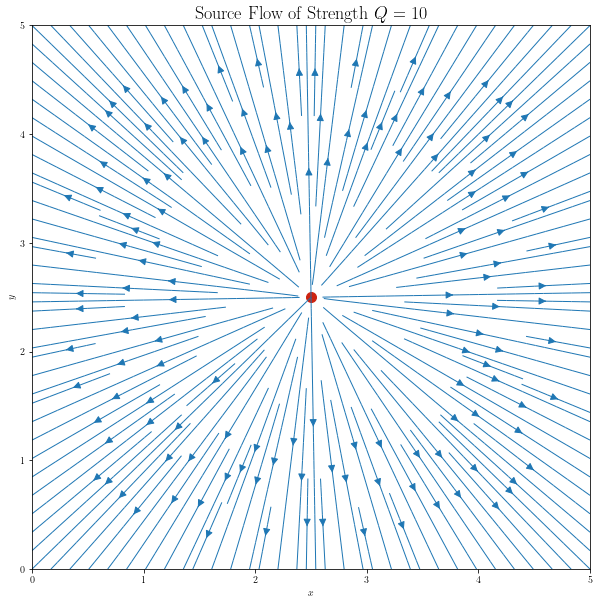

In [6]:
#Plot data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim(x_low, x_high)
plt.ylim(y_low, y_high)
plt.title(r'Source Flow of Strength $Q = {}$'.format(Q),fontsize=18)
plt.streamplot(x_dir, y_dir, u_source, v_source, arrowsize=1.5, density = 2, linewidth = 1.0)
plt.scatter(source_x, source_y, s=100, color='#CD2310');  #semicolon suppresses line from being output

## Sink
A sink has the same velocity components as the source, but there is one key distinction: the source strength $Q$ is *negative* for a sink.

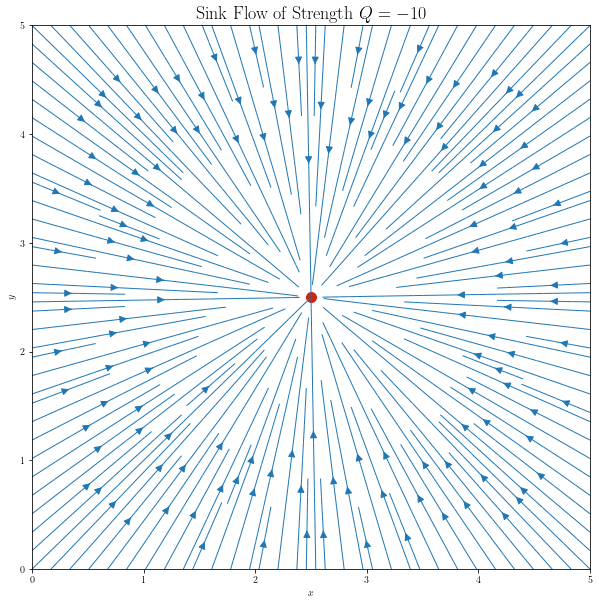

In [7]:
sink_x, sink_y = 2.5, 2.5         #coordinates of the sink
Q_sink = -10                            #strength of sink in [m^3/s]

u_sink = np.zeros((N,N))          #array to store u component of velocity
v_sink = np.zeros((N,N))          #array to store v component of velocity

for k in range(N):
    for j in range(N):
        u_sink[k][j] = Q_sink / (2 * math.pi) * (x_dir[k][j] - source_x)/((x_dir[k][j] - source_x)**2 + (y_dir[k][j] - source_y)**2)
        v_sink[k][j] = Q_sink / (2 * math.pi) * (y_dir[k][j] - source_y)/((x_dir[k][j] - source_x)**2 + (y_dir[k][j] - source_y)**2)

#Plot data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim(x_low, x_high)
plt.ylim(y_low, y_high)
plt.title(r'Sink Flow of Strength $Q = {}$'.format(Q_sink),fontsize=18)
plt.streamplot(x_dir, y_dir, u_sink, v_sink, arrowsize=1.5, density = 2, linewidth = 1.0)
plt.scatter(sink_x, sink_y, s=100, color='#CD2310');  #semicolon suppresses line from being output

# Point Vortex
Similar to the previous two potential flows, a point vortex is also a singularity (viz., the core of the point vortex has infinite velocity). The velocity, streamfunction, and velocity potential of this flow are
$$u_r = 0, \quad u_\theta = \frac{\Gamma}{2\pi r}, \quad \psi = -\frac{\Gamma}{2\pi}\ln r, \quad \phi = \frac{\Gamma}{2\pi}\theta, $$
In Cartesian coordinates, the velocity components $u$ and $v$ are
$$u = \frac{\Gamma}{2\pi}\frac{y - y_{vortex}}{\left(x - x_{vortex} \right)^2 + \left(y - y_{vortex} \right)^2}, \quad v = -\frac{\Gamma}{2\pi}\frac{x - x_{vortex}}{\left(x - x_{vortex} \right)^2 + \left(y - y_{vortex} \right)^2} $$

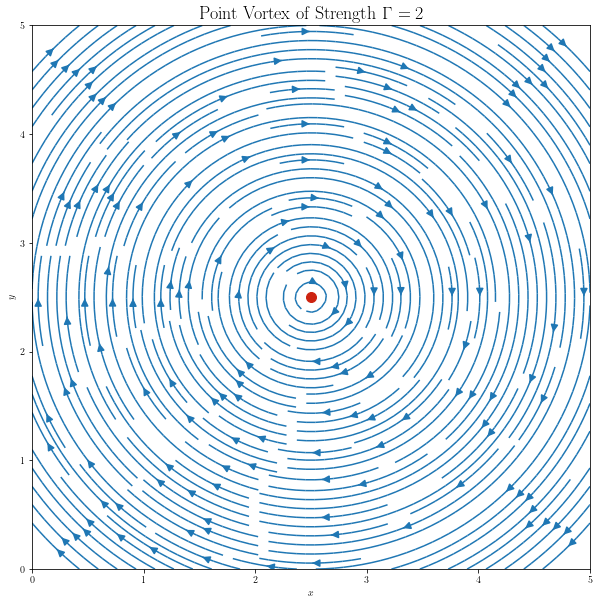

In [8]:
point_x, point_y = 2.5, 2.5           #coordinates of the point vortex
Γ = 2                                 #strength of vortex in [m^3/s]

u_point = np.zeros((N,N))             #array to store u component of velocity
v_point = np.zeros((N,N))             #array to store v component of velocity

for k in range(N):
    for j in range(N):
        u_point[k][j] = Γ/(2 * math.pi) * (y_dir[k][j] - point_y)/((x_dir[k][j] - point_x)**2 + (y_dir[k][j] - point_y)**2)
        v_point[k][j] = -Γ/(2 * math.pi) * (x_dir[k][j] - point_x)/((x_dir[k][j] - point_x)**2 + (y_dir[k][j] - point_y)**2)
        
#Plot data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim(x_low, x_high)
plt.ylim(y_low, y_high)
plt.title(r'Point Vortex of Strength $\Gamma = {}$'.format(Γ), fontsize=18)
plt.streamplot(x_dir, y_dir, u_point, v_point, arrowsize=1.5, density = 2, linewidth = 1.5)
plt.scatter(point_x, point_y, s=100, color='#CD2310');  #semicolon suppresses line from being output

# Dipole/Doublet
A dipole (or doublet) is also a singularity with the following governing equations:
$$u_r = -\frac{D}{\pi r^2}\cos(\theta), \quad u_\theta = -\frac{D}{\pi r^2}\sin(\theta), \quad \psi = -\frac{D}{\pi r}\sin(\theta), \quad \phi = \frac{D}{\pi r}\cos(\theta)$$
where $D$ is the doublet strength. In Cartesian coordinates, the velocity components are
$$u = -\frac{D}{2\pi}\frac{\left(x - x_D\right)^2 - \left(y - y_D\right)^2}{\left((x - x_D)^2 + (y - y_D)^2 \right)^2}, \quad v = -\frac{D}{2\pi}\frac{2\left(x - x_D \right)\left(y - y_D \right)}{\left((x - x_D)^2 + (y - y_D)^2\right)^2}$$
where $(x_D, y_D)$ corresponds to the location of the doublet.

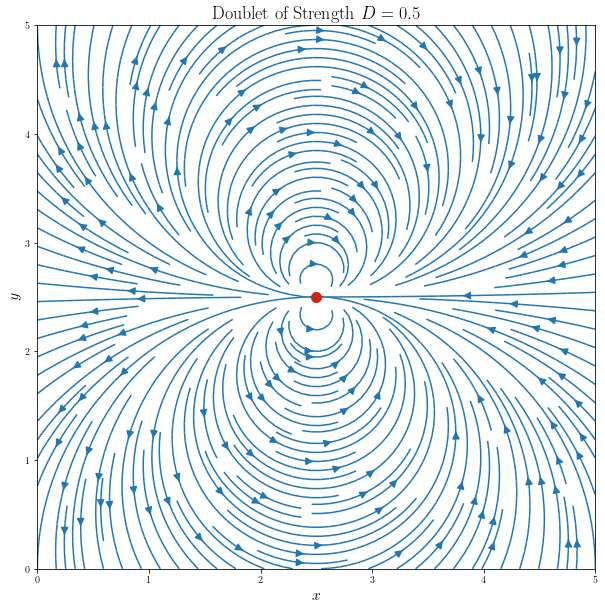

In [9]:
doublet_x, doublet_y = 2.5, 2.5          #coordinates of the doublet
D = 0.5                                  #strength of the doublet in [m^3/s]

u_doublet = np.zeros((N,N))              #array to store u component of velocity
v_doublet = np.zeros((N,N))              #array to store v component of velocity

for k in range(N):
    for j in range(N):
        u_doublet[k][j] = -D / (2 * math.pi) * ((x_dir[k][j] - doublet_x)**2 - (y_dir[k][j] - doublet_y)**2)/((x_dir[k][j] - doublet_x)**2 + (y_dir[k][j] - doublet_y)**2)**2
        v_doublet[k][j] = -D / (2 * math.pi) * (2 * (x_dir[k][j] - doublet_x)*(y_dir[k][j] - doublet_y))/((x_dir[k][j] - doublet_x)**2 + (y_dir[k][j] - doublet_y)**2)**2
        
#Plot data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$y$',fontsize=16)
plt.xlim(x_low, x_high)
plt.ylim(y_low, y_high)
plt.title(r'Doublet of Strength $D = {}$'.format(D),fontsize=18)
plt.streamplot(x_dir, y_dir, u_doublet, v_doublet, arrowsize=1.5, density = 2, linewidth = 1.5)
plt.scatter(doublet_x, doublet_y, s=100, color='#CD2310');  #semicolon suppresses line from being output

# Principle of Superposition 
## Uniform Flow and Source
Because potential flow is linear, the principle of superposition can be applied: in other words, the solutions of each respective component (uniform flow and source) are simply added up to obtain the result. Consider a uniform flow at $0$ degrees and a source of strength $Q$. Applying superposition, the velocity components in Cartesian coordinates are
$$u = \underbrace{U_\infty}_\textrm{Freestream} + \underbrace{\frac{Q}{2\pi}\frac{x - x_{source}}{(x - x_{source})^2 + (y - y_{source})^2}}_\textrm{Source}, \quad v = \frac{Q}{2\pi}\frac{y- y_{source}}{(x - x_{source})^2 + (y - y_{source})^2} $$

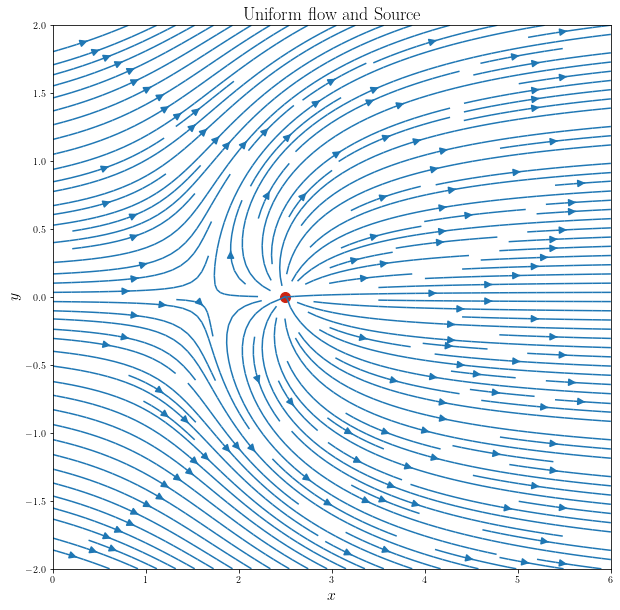

In [10]:
N1 = 200;                                        #number of lines in each direction
x_lower, x_upper = 0, 6                          #x limit boundaries
y_lower, y_upper = -2, 2                         #y limit boundaries
x = np.linspace(x_lower, x_upper, N1)            #points along the grid in the x direction
y = np.linspace(y_lower, y_upper, N1)            #points along the grid in the y direction
X_grid, Y_grid = np.meshgrid(x, y)               #create the grid
U_inf = 1.0                                      #freestream velocity in [m/s]
Q_s = 5.0                                        #strength of source in [m^3/s]
x_s, y_s = 2.5, 0                                #coordinates of source

u_super = np.zeros((N1,N1))                      #array to store u component of superimposed flow
v_super = np.zeros((N1,N1))                      #array to store v component of superimposed flow

for k in range(N1):
    for j in range(N1):
        u_super[k][j] = U_inf + Q_s/(2 * math.pi) * (X_grid[k][j] - x_s)/((X_grid[k][j] - x_s)**2 + (Y_grid[k][j] - y_s)**2)
        v_super[k][j] = Q_s/(2 * math.pi) * (Y_grid[k][j] - y_s)/((X_grid[k][j] - x_s)**2 + (Y_grid[k][j] - y_s)**2)

#Plot data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$y$',fontsize=16)
plt.xlim(x_lower, x_upper)
plt.ylim(y_lower, y_upper)
plt.title(r'Uniform flow and Source',fontsize=18)
plt.streamplot(X_grid, Y_grid, u_super, v_super, arrowsize=1.5, density = 2, linewidth = 1.5)
plt.scatter(x_s, y_s, s=100, color='#CD2310');  #semicolon suppresses line from being output

**Stagnation points** of fluids are where $\mathbf{u} = 0$. First, we look for where $v = 0$, as this provides insight into where along the $y$ axis the stagnation point lies.
$$v = 0 \Longrightarrow y_{stag. pt.} = y_{source}$$
We obtained these results by noting that the numerator of the $v$ component must be 0. Now, we must solve for $u = 0$,
$$u = 0 \Longrightarrow x_{stag. pt.} = x_{source} - \frac{Q}{2\pi U_\infty}$$
On a side note, streamlines are *tangent* to the flow velocity vector $\mathbf{u}$. By virtue, the value of the streamfunction $\psi$ is constant everywhere along a streamline. The streamfunction associated with this flow is
$$\psi = \underbrace{U_\infty y}_\textrm{Free stream} + \underbrace{\frac{Q}{2\pi}\arctan\left(\frac{y - y_{source}}{x - x_{source}} \right)}_\textrm{Source} $$
Along the stagnation (or dividing) streamline, the value of the streamfunction is
$$\psi_{stag} = \frac{Q}{s}$$

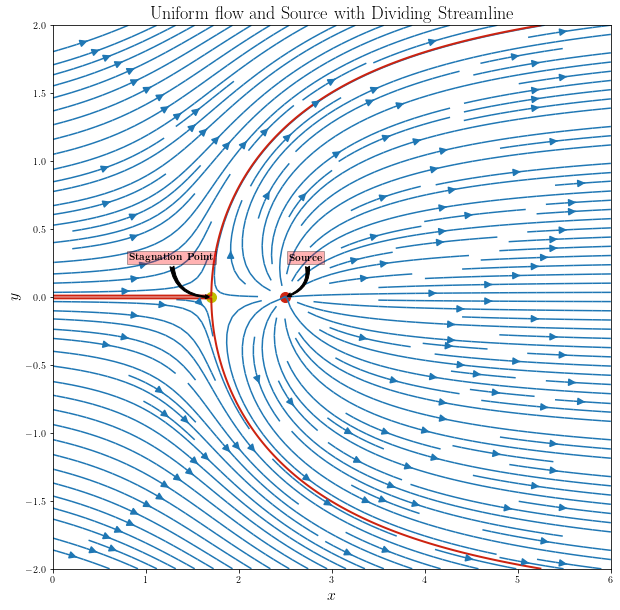

In [11]:
#store the coordinates of the stagnation points
x_stag = x_s - Q_s/(2 * math.pi * U_inf)
y_stag = y_s

ψ = np.zeros((N1,N1))

#Calculate the value of the streamfunction ψ, which is needed to plot the stagnation streamline
for k in range(N1):
    for j in range(N1):
        ψ[k][j] = U_inf * Y_grid[k][j] + (Q_s/(2 * math.pi)) * np.arctan2((Y_grid[k][j] - y_s), (X_grid[k][j] - x_s))

#plot the data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$y$',fontsize=16)
plt.xlim(x_lower, x_upper)
plt.ylim(y_lower, y_upper)
plt.title(r'Uniform flow and Source with Dividing Streamline',fontsize=18)
plt.streamplot(X_grid, Y_grid, u_super, v_super, arrowsize=1.5, density = 2, linewidth = 1.5)
plt.scatter(x_s, y_s, s=100, color='#CD2310')  
plt.scatter(x_stag, y_stag, s=100, color = 'y')
plt.contour(X_grid, Y_grid, ψ, levels=[-Q_s/2, Q_s/2], colors = '#CD2310', linestyles = 'solid', linewidths = 2)
plt.annotate(r'\textbf{Stagnation Point}', xy=(x_stag, y_stag), xytext=(-40,35), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='square,pad=0.2', fc='red', alpha=0.3),
            arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3,rad=0.5', 
            color='black'))
plt.annotate(r'\textbf{Source}', xy=(x_s, y_s), xytext=(20,35), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='square,pad=0.2', fc='red', alpha=0.3),
            arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3,rad=-0.5', 
            color='black'));

# Pressure Coefficient
The pressure coefficient $C_p$ is defined by
$$C_p = \frac{p - p_\infty}{\frac{1}{2}\rho \mathbf{u}^2}$$
where $p_\infty$ is the ambient pressure and $\mathbf{u}$ is the velocity *vector*. Assuming the fluid is incompressible, inviscid, and irrotational (i.e. potential flow), $C_p$ can be rewritten as
$$C_p = 1 - \left(\frac{\mathbf{u}}{U_\infty} \right)^2$$
At a stagnation point, $C_p = 1$ because $\mathbf{u} = 0$ by definition. However, for compressible flow, $C_p$ can be greater than $1.0$.

<ipython-input-12-fc20ca5a3af8>:21: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  CS = colorcont.ax.contour(X_grid, Y_grid, C_p, levels=np.linspace(0,1.0,10), origin='lower', extend='both',
<ipython-input-12-fc20ca5a3af8>:24: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  colorcont.ax.clabel(CS, fontsize=10)


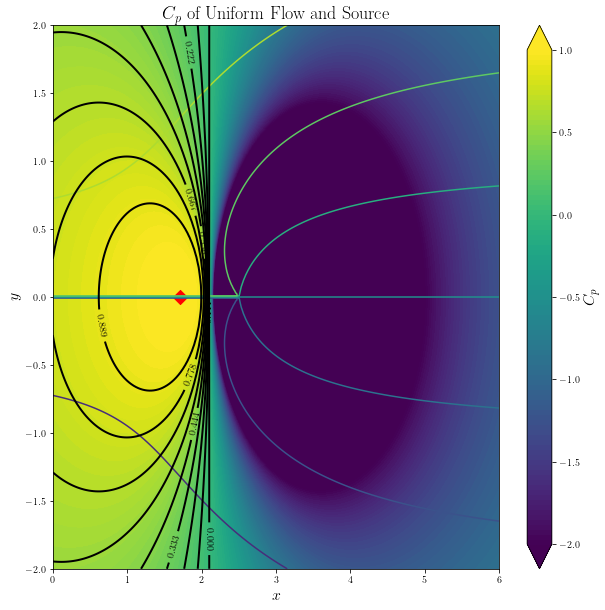

In [12]:
#Evaluate the pressure coefficient
C_p = np.zeros((N1,N1))

for k in range(N1):
    for j in range(N1):
        C_p[k][j] = 1 - (((u_super[k][j])**2 + (v_super[k][j])**2)/ U_inf)**2
        
#plot the data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$y$',fontsize=16)
plt.title(r'$C_p$ of Uniform Flow and Source', fontsize=18)
plt.xlim(x_lower, x_upper)
plt.ylim(y_lower, y_upper)
contour_level = np.linspace(-2.0, 1.0, 100)
colorcont = plt.contourf(X_grid, Y_grid, C_p, levels=contour_level, extend='both')
colorbar = plt.colorbar(colorcont)
colorbar.set_ticks([-2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5])
colorbar.ax.set_ylabel(r'$C_p$', fontsize=16)
plt.contour(X_grid, Y_grid, ψ, linestyles='solid')
CS = colorcont.ax.contour(X_grid, Y_grid, C_p, levels=np.linspace(0,1.0,10), origin='lower', extend='both',
                linewidths=2, colors='k', linestyles='solid')
pts = [(x_stag, y_stag)]
colorcont.ax.clabel(CS, fontsize=10)
plt.scatter(x_stag, y_stag, color='r', s=100, marker='D');

This contour plot visually depicts that $C_p = 1$ at the stagnation point for incompressible flow. As the contours converge toward the stagnation point at $(x_{s}, y_s)$, $C_p$ gets closer and closer to 1. Interestingly, from this plot, we can see that there appears to be a vertical asymptote that splits off the negative and positive $C_p$ values. To further verify that the stagnation point has $C_p = 1$, a plot of $C_p$ vs. $x$ is shown below.

-35270281.734899156


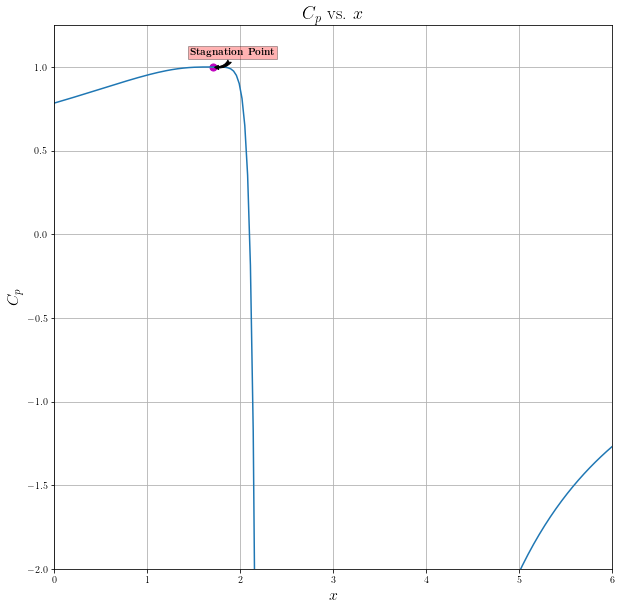

In [13]:
#import package that helps with the calculations
from numpy import unravel_index

Cp_min = -2.0         #np.round(np.min(C_p)) didn't seem to work; generated a number on the order of -3.53e7
Cp_max = np.round(np.max(C_p)) + 0.25 #+0.25 is a little extra padding room on the Cp axis of the graph
totalPts = N1**2      #number of nodes on the mesh grid
[x_max, y_max] = unravel_index(C_p.argmax(), C_p.shape)  #obtains index in form [x, y] where Cp is at max
Cpmax_array = np.zeros((N1))
#print([x_max, y_max])
#print(np.argmax(C_p))

for j in range(N1):
    Cpmax_array[j] = C_p[x_max][j]
    
print(np.min(Cpmax_array))    

#plot the data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$C_p$',fontsize=16)
plt.title(r'$C_p$ vs. $x$', fontsize=18)
plt.xlim(x_lower, x_upper)
plt.ylim(Cp_min, Cp_max)
plt.plot(x, Cpmax_array)
plt.grid(True)
plt.scatter(x_stag, C_p[x_max][y_max], s=50, color = 'm')
plt.annotate(r'\textbf{Stagnation Point}', xy=(x_stag,C_p[x_max][y_max]), xytext=(20,10), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='square,pad=0.2', fc='red', alpha=0.3),
            arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3,rad=-0.5', 
            color='black'));

# Cylinder Modeled as Doublet and Uniform Flow
Interestingly, the minimum value of $C_p$ for this plot is *very* small: $-3.52\times10^7$. However, we should obtain less extreme results when plotting a circular cylinder modeled with a uniform flow and doublet. The theoretical result for this flow can be obtained using Bernoulli's equation:
$$p + \frac{1}{2}\rho \mathbf{u}^2 = p_\infty + \frac{1}{2}\rho U_\infty^2 \Longrightarrow p(\theta) = p_\infty - \frac{1}{2}\left(u_r^2 + u_\theta^2 \right)$$
$$u_r = U_{\infty}\left(1 - \frac{R^2}{r^2}\right)\cos\theta,\quad u_\theta = -U_\infty\left(1 + \frac{R^2}{r^2}\right)\sin\theta$$
$$C_p = 1 - \left(\frac{\mathbf{u}}{U_\infty}\right)^2 = 1 - \left(\frac{U_\infty(2\sin\theta)}{U_\infty}\right)^2 = 1 - 4\sin^2\theta$$
where $R$ is the radius of the cylinder. In Cartesian coordinates, the velocity components are
$$u = \underbrace{U_\infty}_\textrm{Free stream} - \underbrace{\frac{D}{2\pi}\frac{\left(x - x_D\right)^2 - \left(y - y_D\right)^2}{\left((x - x_D)^2 + (y - y_D)^2 \right)^2}}_\textrm{Doublet}, \quad v = -\frac{D}{2\pi}\frac{2\left(x - x_D \right)\left(y - y_D \right)}{\left((x - x_D)^2 + (y - y_D)^2\right)^2}$$
where $(x_D, y_D)$ is the location of the doublet.

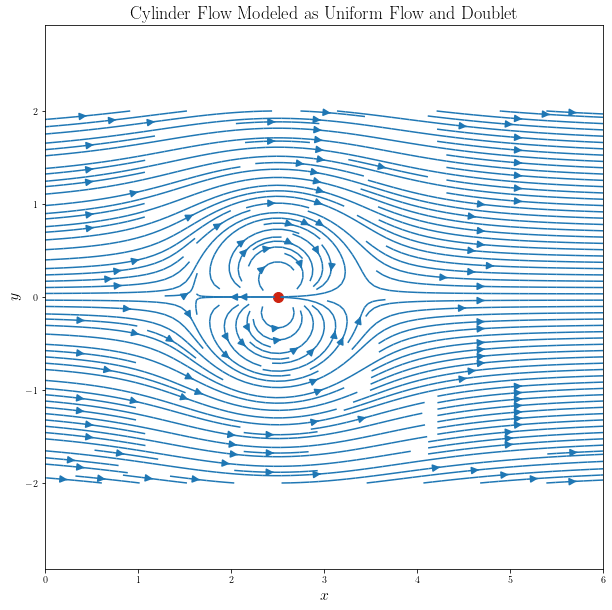

In [14]:
x_D, y_D = 2.5, 0                           #coordinates of the doublet expressed as (xD, yD)
D_c = 5.0                                   #strength of the doublet in [m^3/s]
U_infty = 1.0                               #velocity of freestream in [m/s]
u_cylinder = np.zeros((N1,N1))              #array to store u component of velocity
v_cylinder = np.zeros((N1,N1))              #array to store v component of velocity

for k in range(N1):
    for j in range(N1):
        u_cylinder[k][j] = U_infty - D_c / (2 * math.pi) * ((X_grid[k][j] - x_D)**2 - (Y_grid[k][j] - y_D)**2)/((X_grid[k][j] - x_D)**2 + (Y_grid[k][j] - y_D)**2)**2
        v_cylinder[k][j] = -D_c / (2.0 * math.pi) * (2*(X_grid[k][j] - x_D)*(Y_grid[k][j] - y_D))/((X_grid[k][j] - x_D)**2 + (Y_grid[k][j] - y_D)**2)**2
        
#Plot data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$y$',fontsize=16)
plt.xlim(x_lower, x_upper)
plt.ylim(y_lower, y_upper)
plt.title(r'Cylinder Flow Modeled as Uniform Flow and Doublet',fontsize=18)
plt.streamplot(X_grid, Y_grid, u_cylinder, v_cylinder, arrowsize=1.5, density = 2, linewidth = 1.5)
plt.scatter(x_D, y_D, s=100, color='#CD2310')
plt.axis('equal');

The stagnation points of this flow are
$$x_{stag. pt.} = x_D \pm\sqrt{\frac{D}{2\pi U_\infty}}, \quad y_{stag. pt.} = y_{D}$$
where $x_D$ is the $x$ coordinate of the doublet and $y_D$ is the $y$ coordinate of the doublet. It is also important to note that the distance from the stagnation point to the doublet is equivalent to the radius $R$ of the cylinder. Additionally, the streamfunction of this flow is necessary to obtain the level of the stagnation streamline.
$$\psi = U_\infty y -\frac{D}{2\pi}\frac{y - y_D}{(x - x_D)^2 + (y - y_D)^2} $$
A plot containing the stagnation streamline and points is shown below.

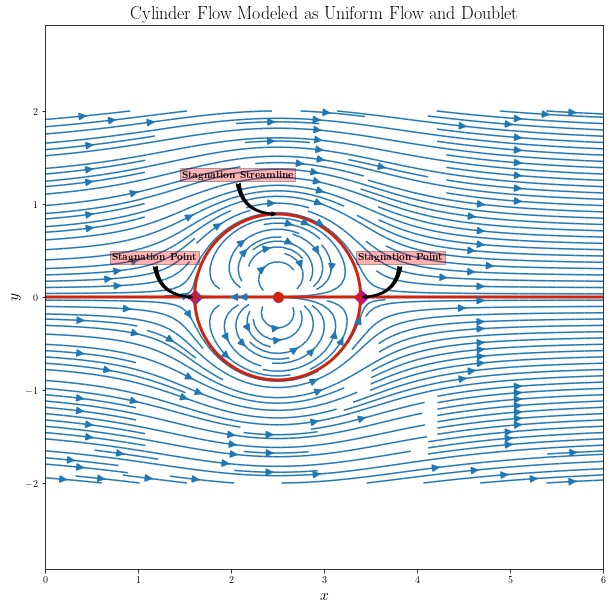

In [15]:
#Calculate the location of the stagnation points
x_stag1, y_stag1 = x_D + math.sqrt(D_c/(2 * math.pi * U_infty)), y_D
x_stag2, y_stag2 = x_D - math.sqrt(D_c/(2 * math.pi * U_infty)), y_D

ψc = np.zeros((N1,N1))

for k in range(N1):
    for j in range(N1):
        ψc[k][j] = U_infty * Y_grid[k][j] - D_c/(2 * math.pi) * (Y_grid[k][j] - y_D)/((X_grid[k][j] - x_D)**2 + (Y_grid[k][j] - y_D)**2)

#Plot data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$y$',fontsize=16)
plt.xlim(x_lower, x_upper)
plt.ylim(y_lower, y_upper)
plt.title(r'Cylinder Flow Modeled as Uniform Flow and Doublet',fontsize=18)
plt.streamplot(X_grid, Y_grid, u_cylinder, v_cylinder, arrowsize=1.5, density = 2, linewidth = 1.5)
plt.contour(X_grid, Y_grid, ψc, colors = '#CD2310', linestyles = 'solid', linewidths = 3)
plt.scatter(x_D, y_D, s=100, color='#CD2310')
plt.scatter([x_stag1, x_stag2], [y_stag1, y_stag2], s=100, color='m', marker='D')
plt.annotate(r'\textbf{Stagnation Point}', xy=(x_stag1, y_stag1), xytext=(40,35), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='square,pad=0.2', fc='red', alpha=0.3),
            arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3,rad=-0.5', 
            color='black'))
plt.annotate(r'\textbf{Stagnation Point}', xy=[x_stag2, y_stag2], xytext=(-40,35), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='square,pad=0.2', fc='red', alpha=0.3),
            arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3,rad=0.5', 
            color='black'))
plt.annotate(r'\textbf{Stagnation Streamline}', xy=[x_D, x_D - x_stag2], xytext=(-40,35), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='square,pad=0.2', fc='red', alpha=0.3),
            arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3,rad=0.5', 
            color='black'))
plt.axis('equal');

Now, let's generate a contour plot of the flow (similar to what we did for the uniform flow + source) to visually estimate if $C_p = 1.0$ at the stagnation points.

<ipython-input-16-fe88692d3413>:23: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  CS = colorcont.ax.contour(X_grid, Y_grid, Cp_c, levels=np.linspace(0,1.0,10), origin='lower', extend='both',
<ipython-input-16-fe88692d3413>:26: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  colorcont.ax.clabel(CS, fontsize=10)


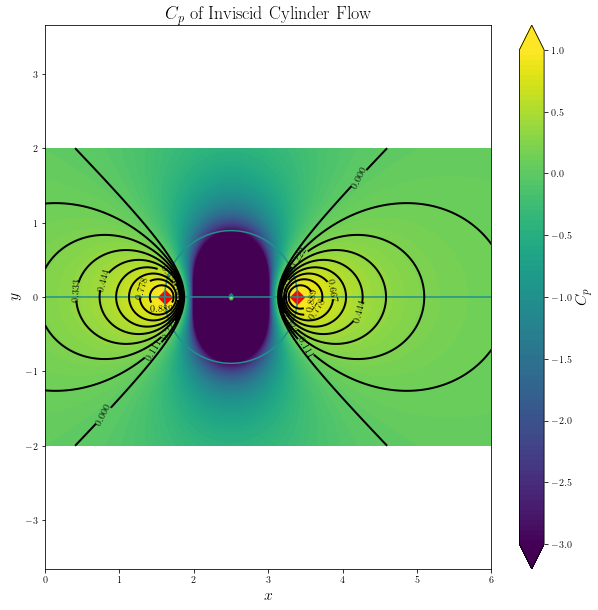

In [16]:
#contour
Cp_c = np.zeros((N1,N1))

for k in range(N1):
    for j in range(N1):
        Cp_c[k][j] = 1 - ((u_cylinder[k][j])**2 + (v_cylinder[k][j])**2) / (U_infty)**2
        
#print(np.max(Cp_c)) we can verify with this statement that the maximum is 1.0 and can deduce that the stagnation point is where this value occurs from the color contour plot

#plot the data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$y$',fontsize=16)
plt.title(r'$C_p$ of Inviscid Cylinder Flow', fontsize=18)
plt.xlim(x_lower, x_upper)
plt.ylim(y_lower, y_upper)
contour_level = np.linspace(-3.0, 1.0, 100)
colorcont = plt.contourf(X_grid, Y_grid, Cp_c, levels=contour_level, extend='both')
colorbar = plt.colorbar(colorcont)
colorbar.set_ticks([-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5])
colorbar.ax.set_ylabel(r'$C_p$', fontsize=16)
cont = plt.contour(X_grid, Y_grid, ψc, linestyles='solid')
CS = colorcont.ax.contour(X_grid, Y_grid, Cp_c, levels=np.linspace(0,1.0,10), origin='lower', extend='both',
                linewidths=2, colors='k', linestyles='solid')
pts = [(x_stag, y_stag)]
colorcont.ax.clabel(CS, fontsize=10)
plt.scatter([x_stag1, x_stag2], [y_stag1, y_stag2], color='r', s=100, marker='D')
plt.axis('equal');

As the contours decrease in size and approach the stagnation point, $C_p \to 1$, which is also seen in the uniform flow and source flow.

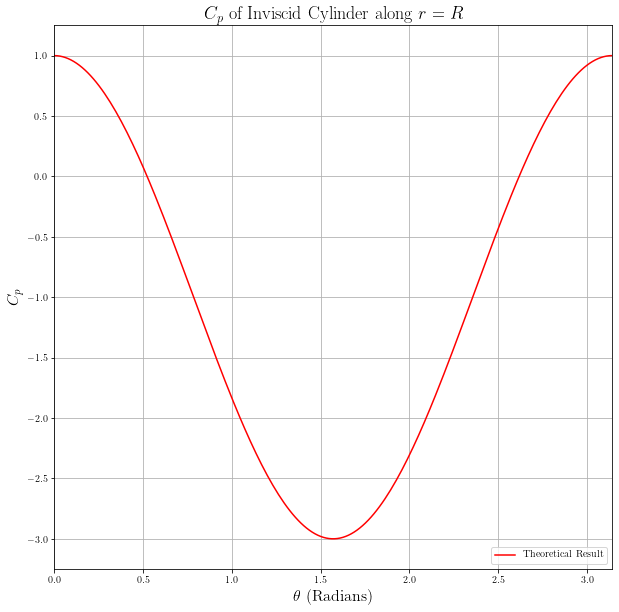

In [17]:
#cp vs θ
θ = np.linspace(0, math.pi, N1)
Cp_theoretical = 1 - 4 * (np.sin(θ))**2    #theoretical result
y_bot, y_top = np.round(np.min(Cp_theoretical)) - 0.25, np.round(np.max(Cp_theoretical)) + 0.25 #+/-0.25 is extra padding
x_bot, x_top = 0, math.pi

#plot the data
plt.figure(figsize=(L,H))
plt.xlabel(r'$\theta$ (Radians)',fontsize=16)
plt.ylabel(r'$C_p$',fontsize=16)
plt.title(r'$C_p$ of Inviscid Cylinder along $r = R$', fontsize=18)
plt.xlim(x_bot, x_top)
plt.ylim(y_bot, y_top)
plt.grid(True)
plt.plot(θ, Cp_theoretical, linewidth=1.5, color='r')
plt.legend([r'Theoretical Result'], loc='lower right');

# Actual Cylinder Flow
This pressure distribution suggests that there is no force (i.e. drag and lift are zero) on the cylinder due to its symmetry: the top and bottom half are symmetrical so $L = 0$ and the flow is symmetric on the left and right halves so $D = 0$. While these results may seem accurate, experimental data contradict this: there is *non-zero* drag on the cylinder due to the presence of viscous effects, which arises as a result of a thin viscous boundary layer. However, potential flow theory assumes that the fluid is *inviscid*, so potential flow theory fails to provide physically accurate results. The actual flow of a cylinder is beyond the scope of this notebook and will be implemented in future notebooks. But, in the meantime, a temporary solution can be provided: the cylinder above in conjunction with a point vortex, which generates a lifting force on the cylinder. The corresponding velocity components and streamfunction are
$$u = \underbrace{U_\infty}_\textrm{Free stream} - \underbrace{\frac{D}{2\pi}\frac{\left(x - x_D\right)^2 - \left(y - y_D\right)^2}{\left((x - x_D)^2 + (y - y_D)^2 \right)^2}}_\textrm{Doublet} + \underbrace{\frac{\Gamma}{2\pi}\frac{y - y_{vortex}}{\left(x - x_{vortex} \right)^2 + \left(y - y_{vortex} \right)^2}}_\textrm{Point Vortex} $$
$$v = \underbrace{-\frac{D}{2\pi}\frac{2\left(x - x_D \right)\left(y - y_D \right)}{\left((x - x_D)^2 + (y - y_D)^2\right)^2}}_\textrm{Doublet} - \underbrace{\frac{\Gamma}{2\pi}\frac{x - x_{vortex}}{\left(x - x_{vortex} \right)^2 + \left(y - y_{vortex} \right)^2}}_\textrm{Point Vortex}$$
$$\psi = \underbrace{U_\infty y}_\textrm{Free stream} - \underbrace{\frac{D}{2\pi}\frac{y - y_D}{(x - x_D)^2 + (y - y_D)^2}}_\textrm{Doublet} + \underbrace{\frac{\Gamma}{2\pi}\ln\sqrt{(x - x_{vortex})^2 + (y - y_{vortex})^2}}_\textrm{Point Vortex}$$
With respect to the $x$ axis, the stagnation points can be found at an angle $\beta$
$$\beta = \arcsin\left(\frac{\Gamma}{4\pi U_\infty R} \right) \Longrightarrow R\sin\beta = \Delta y \text{ to stagnation point} = -\frac{\Gamma}{4\pi U_\infty}$$
$$R\cos\beta = \pm\Delta x \text{ to stagnation point} $$
However, $\cos\beta$ is not known immediately, so we must use the trigonometric relationship $\sin^2\beta + \cos^2\beta = 1$. Solving for $\cos^2\beta$, we obtain
$$\cos^2\beta = 1 - \left(\frac{\Gamma}{4\pi U_\infty R}\right)^2 \Longrightarrow \Delta x = R\cos\beta = \sqrt{R^2\cos^2\beta} = \sqrt{R^2 - \left(\frac{\Gamma}{4\pi U_\infty}\right)^2}$$
Converting this to $x$ and $y$ values that can be used, we obtain
$$x_{stag. pt.} = x_D \pm \Delta x = x_D \pm \sqrt{R^2 - \left(\frac{\Gamma}{4\pi U_\infty}\right)^2}, \quad y_{stag. pt.} = y_D + \Delta y = y_D - \frac{\Gamma}{4\pi U_\infty}$$

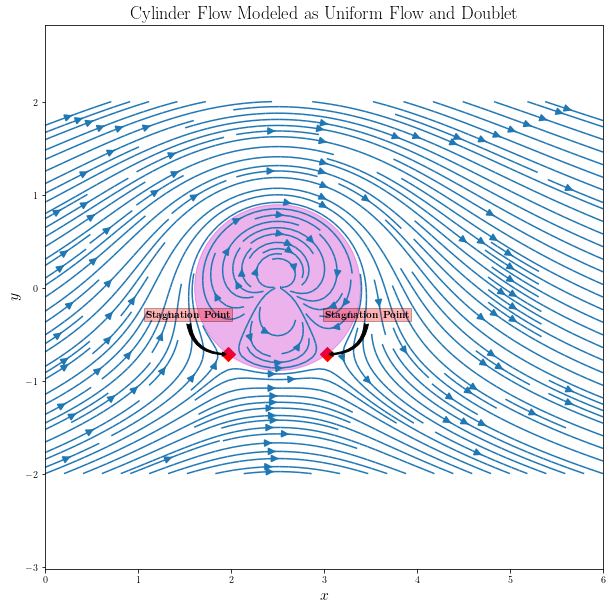

In [49]:
#Cylinder + Point Vortex
u_lift = np.zeros((N1,N1))        #array to store u component of velocity
v_lift = np.zeros((N1,N1))        #array to store v component of velocity
ψ_lift = np.zeros((N1,N1))        #array to store streamfunction
Cp_lift = np.zeros((N1,N1))       #array to store Cp
x_v, y_v = 2.5, 0                 #coordinates of the point vortex
R = x_D - x_stag2                 #radius of cylinder (only works if y_D = 0)
Γ_lift = 9.0                      #strength of point vortex

#Coordinates of Stagnation Points
xlift_stag1, ylift_stag1 = x_D + math.sqrt(R**2 - (Γ_lift/(4 * math.pi * U_infty))**2), y_D - Γ_lift/(4 * math.pi * U_infty)
xlift_stag2, ylift_stag2 = x_D - math.sqrt(R**2 - (Γ_lift/(4 * math.pi * U_infty))**2), y_D - Γ_lift/(4 * math.pi * U_infty)

for k in range(N1):
    for j in range(N1):
        u_lift[k][j] = u_cylinder[k][j] + Γ_lift/(2 * math.pi) * (Y_grid[k][j] - y_v)/((X_grid[k][j] - x_v)**2 + (Y_grid[k][j] - y_v)**2)
        v_lift[k][j] = v_cylinder[k][j] - Γ_lift/(2 * math.pi) * (X_grid[k][j] - x_v)/((X_grid[k][j] - x_v)**2 + (Y_grid[k][j] - y_v)**2)
        ψ_lift[k][j] = ψc[k][j] + Γ_lift/(4 * math.pi) * np.log(np.sqrt((X_grid[k][j] - x_v)**2 + (Y_grid[k][j] - y_v)**2))
        Cp_lift[k][j] = 1 - ((u_lift[k][j])**2 + (v_lift[k][j])**2) / (U_infty)**2
        
#Plot the data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$y$',fontsize=16)
plt.xlim(x_lower, x_upper)
plt.ylim(y_lower, y_upper)
plt.title(r'Cylinder Flow Modeled as Uniform Flow and Doublet',fontsize=18)
plt.streamplot(X_grid, Y_grid, u_lift, v_lift, arrowsize=1.5, density = 2, linewidth = 1.5)
cylinder = plt.Circle((x_D, y_D), R, color='m', alpha=0.3)
plt.gca().add_patch(cylinder)
plt.scatter([xlift_stag1, xlift_stag2], [ylift_stag1, ylift_stag2], color='r', s=100, marker='D')
plt.annotate(r'\textbf{Stagnation Point}', xy=(xlift_stag1, ylift_stag1), xytext=(40,35), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='square,pad=0.2', fc='red', alpha=0.3),
            arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3,rad=-0.5', 
            color='black'))
plt.annotate(r'\textbf{Stagnation Point}', xy=(xlift_stag2, ylift_stag2), xytext=(-40,35), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='square,pad=0.2', fc='red', alpha=0.3),
            arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3,rad=0.5', 
            color='black'))
plt.axis('equal');

As $\Gamma$ increases in value, the streamlines seem to converge toward a single point known as the *critical point*. There is a critical point where the stagnation points on both ends of the cylinder converge to a single point at either $\theta_{crit} = \pi, \frac{3\pi}{2}$. The critical value of $\Gamma$ that results in this is
$$\Gamma_{crit} = 4\pi U_\infty R$$
Let's plot $C_p$ everywhere along the plot to determine if the cylinder generates lift via an uneven pressure distribution on the upper and lower hemispheres.

<ipython-input-60-15a5f1d7a6cc>:13: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  CS = colorcontour.ax.contour(X_grid, Y_grid, Cp_lift, levels=np.linspace(-2.0, 1.0, 7), origin='lower', extend='both',
<ipython-input-60-15a5f1d7a6cc>:16: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  colorcontour.ax.clabel(CS, fontsize=10)


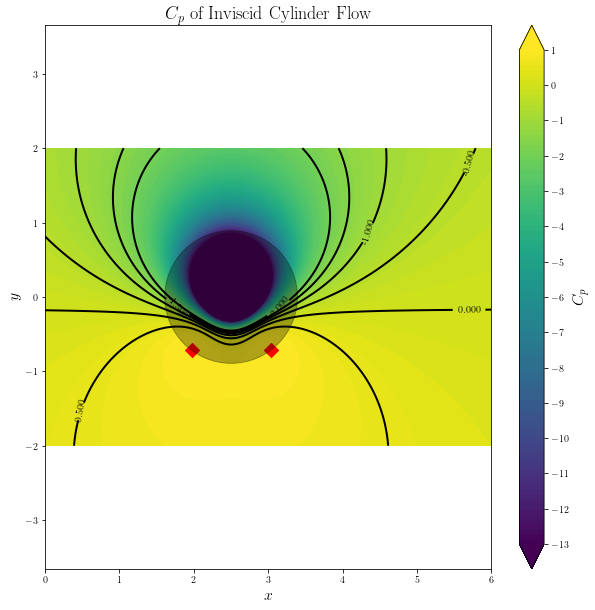

In [60]:
#plot the data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$y$',fontsize=16)
plt.title(r'$C_p$ of Inviscid Cylinder Flow', fontsize=18)
plt.xlim(x_lower, x_upper)
plt.ylim(y_lower, y_upper)
contour_level = np.linspace(-13.0, 1.0, 100)
colorcontour = plt.contourf(X_grid, Y_grid, Cp_lift, levels=contour_level, extend='both')
colorbar1 = plt.colorbar(colorcontour)
colorbar1.set_ticks([-13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0])
colorbar1.ax.set_ylabel(r'$C_p$', fontsize=16)
CS = colorcontour.ax.contour(X_grid, Y_grid, Cp_lift, levels=np.linspace(-2.0, 1.0, 7), origin='lower', extend='both',
                linewidths=2, colors='k', linestyles='solid')
pts = [(x_stag, y_stag)]
colorcontour.ax.clabel(CS, fontsize=10)
cylinder = plt.Circle((x_D, y_D), R, color='k', alpha=0.3)
plt.gca().add_patch(cylinder)
plt.scatter([xlift_stag1, xlift_stag2], [ylift_stag1, ylift_stag2], color='r', s=100, marker='D')
plt.axis('equal');

From the contour plot above, we can see that from $\theta = (\pi, 2\pi)$, the value of $C_p$ has a much larger value (viz., more positive) compared to the upper hemisphere of the cylinder. So, to obtain the equation of $C_p(\theta)$, we use
$$C_p = 1 - \left(\frac{\mathbf{u}}{U_\infty}\right)^2 $$
where $\mathbf{u} = u_r^2 + u_\theta^2$. The radial and $\theta$ components are defined by
$$u_r = U_\infty\left(1 - \frac{R^2}{r^2}\right)\cos\theta $$
$$u_\theta = -U_\infty\left(1 + \frac{R^2}{r^2}\right)\sin\theta - \frac{\Gamma}{2\pi r} $$
When $r = R$, the components reduce to
$$u_r = 0, \quad u_\theta = -2U_\infty\sin\theta - \frac{\Gamma}{2\pi R}$$
So, plugging this in yields
$$C_p(\theta) = 1 - \left(\frac{-2U_\infty\sin\theta - \frac{\Gamma}{2\pi R}}{U_\infty} \right)^2$$

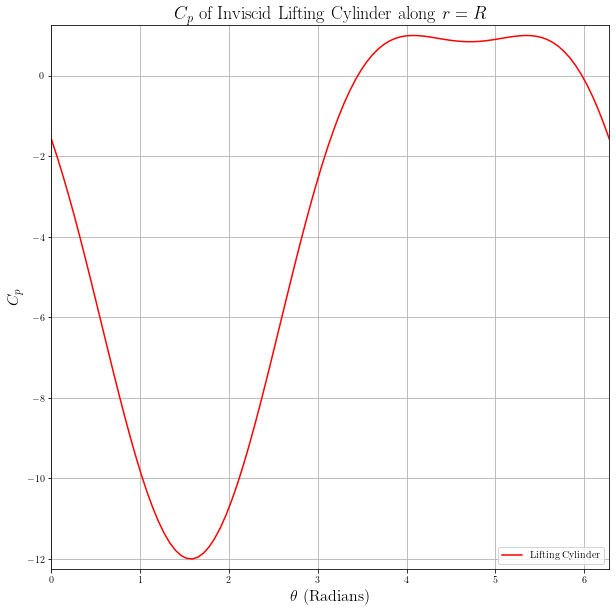

In [67]:
#plot of cp(θ)
θ_vals = np.linspace(0, 2*math.pi, 100)
CpLiftTheoretical = 1 - ((-2 * U_infty * np.sin(θ_vals) - Γ_lift/(2 * math.pi * R))/(U_infty))**2
θ_left, θ_right = 0, 2*math.pi   #Limits of the θ axis
height_min, height_max = np.min(CpLiftTheoretical) - 0.25, np.max(CpLiftTheoretical) + 0.25

#plot the data
plt.figure(figsize=(L,H))
plt.xlabel(r'$\theta$ (Radians)',fontsize=16)
plt.ylabel(r'$C_p$',fontsize=16)
plt.title(r'$C_p$ of Inviscid Lifting Cylinder along $r = R$', fontsize=18)
plt.xlim(θ_left, θ_right)
plt.ylim(height_min, height_max)
plt.grid(True)
plt.plot(θ_vals, CpLiftTheoretical, linewidth=1.5, color='r')
plt.legend([r'Lifting Cylinder'], loc='lower right');